<a href="https://colab.research.google.com/github/Raman-Raje/colab_notebooks/blob/master/article_segmentation_fcn_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About Dataset

* 101 images for each image and annotation class are present

* There are three classes: text area, picture area, background
* 1 ==> Pixels on the mask with color 255, 0, 0 (rgb, red color) correspond to picture area.
* 2 ==> pixels with color 0, 0, 255 (rgb, blue color) correspond to text area.
* 0 ==> all other pixels correspond to background.

In [0]:
# get the datset 
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar 

--2020-03-29 15:00:30--  https://archive.ics.uci.edu/ml/machine-learning-databases/00306/dataset_segmentation.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410202288 (391M) [application/x-httpd-php]
Saving to: ‘dataset_segmentation.rar’

dataset_segmentatio 100%[===================>] 391.20M  59.8MB/s    in 6.2s    

2020-03-29 15:00:37 (63.3 MB/s) - ‘dataset_segmentation.rar’ saved [410202288/410202288]



In [0]:
! pip install patool
import patoolib
patoolib.extract_archive("/content/dataset_segmentation.rar", outdir="./")

     |████████████████████████████████| 81kB 4.0MB/s 
patool: Extracting /content/dataset_segmentation.rar ...
patool: running /usr/bin/unrar x -- /content/dataset_segmentation.rar
patool:     with cwd='./'
patool: ... /content/dataset_segmentation.rar extracted to `./'.


'./'

In [0]:
! pip install keras_segmentation

     |████████████████████████████████| 3.3MB 7.7MB/s 
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-cp36-none-any.whl size=29072 sha256=82ec741c8c91ebb8bdf6021fc18a38fd83baa409093ff8d2c1c959eb8f399273
  Stored in directory: /root/.cache/pip/wheels/d0/bb/c0/6aad88b38f6e46db048bed4cccb904a5897055a8ab6fbd4dfc
Successfully built keras-segmentation
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: imageio 2.4.1
    Uninstalling imageio-2.4.1:
      Successfully uninstalled imageio-2.4.1


In [0]:
%tensorflow_version 1.x
import os
import cv2
import shutil
import random 

import numpy as np
import pandas as pd
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt

from keras_segmentation.models.fcn import fcn_8_vgg,fcn_8
from keras_segmentation.predict import predict_multiple,predict

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
rootdir = "./content/dataset_segmentation"
pre_dataset = "./content/dataset/"

if not os.path.exists(pre_dataset):
        os.makedirs(pre_dataset)

directory = ["./content/data/train/annotations/","./content/data/test/annotations/",
             "./content/data/train/images/","./content/data/test/images/",
             "./content/data/val/annotations/","./content/data/val/images/",
             "./content/data/images/","./content/data/annotations/","/content/content/checkpoints/"
             ]
for ed in directory:
    if not os.path.exists(ed):
        os.makedirs(ed)

In [0]:
os.remove("/content/dataset_segmentation/documentation.txt")

In [0]:
# resizing the image
for subdir, dirs, files in os.walk("/content/dataset_segmentation/"):
    for i,file in enumerate(files):
        path = subdir+file
        print(i,path)
        img = cv2.imread(path)
        img_ = cv2.resize(img,(248,351),interpolation=cv2.INTER_AREA)
        file = file.replace(file.split(".")[-1],"png")
        path_ = pre_dataset + file
        cv2.imwrite(path_,img_)


0 /content/dataset_segmentation/40_m.png
1 /content/dataset_segmentation/29_m.png
2 /content/dataset_segmentation/4g.tif
3 /content/dataset_segmentation/14_m.png
4 /content/dataset_segmentation/51.jpg
5 /content/dataset_segmentation/2cw_m.bmp
6 /content/dataset_segmentation/55.jpg
7 /content/dataset_segmentation/48_m.png
8 /content/dataset_segmentation/56.jpg
9 /content/dataset_segmentation/3g_m.bmp
10 /content/dataset_segmentation/4g_m.bmp
11 /content/dataset_segmentation/1.jpg
12 /content/dataset_segmentation/4cw_m.bmp
13 /content/dataset_segmentation/39_m.png
14 /content/dataset_segmentation/64_m.png
15 /content/dataset_segmentation/14.jpg
16 /content/dataset_segmentation/33_m.png
17 /content/dataset_segmentation/3_m.png
18 /content/dataset_segmentation/10.jpg
19 /content/dataset_segmentation/74.jpg
20 /content/dataset_segmentation/69_m.png
21 /content/dataset_segmentation/2cw.bmp
22 /content/dataset_segmentation/65_m.png
23 /content/dataset_segmentation/53_m.png
24 /content/dataset

In [0]:
for filename in os.listdir("/content/content/dataset"):
    if "_m" in filename:
        shutil.move("/content/content/dataset/"+filename,"/content/content/data/annotations/"+filename)
    else:
        shutil.move("/content/content/dataset/"+filename,"/content/content/data/images/"+filename)
        
 

In [0]:
def annoted_image(img):
    img_ = np.zeros(img.shape).astype('uint8')

    #Isolate the areas where the color is 255(in first channel) and 255 (in last channel)
    picture_area =np.where((img[:,:,0]==255))
    text_area = np.where((img[:,:,2] == 255))

    # create a new image with the same shape and replace correspoding pixels as per classes
    img_[picture_area] = 1
    img_[text_area] = 2
    
    # return the annotated image
    return img_

In [0]:
for subdir, dirs, files in os.walk("/content/content/data/annotations"):
    for ef in files:
        path = "/content/content/data/annotations/" + ef
        print(path)
        img = cv2.imread(path)
        img_ = annoted_image(img)
        cv2.imwrite(path,img_)
        os.rename(path,path.replace("_m",""))

/content/content/data/annotations/40_m.png
/content/content/data/annotations/29_m.png
/content/content/data/annotations/14_m.png
/content/content/data/annotations/7s_m.png
/content/content/data/annotations/48_m.png
/content/content/data/annotations/39_m.png
/content/content/data/annotations/64_m.png
/content/content/data/annotations/33_m.png
/content/content/data/annotations/3_m.png
/content/content/data/annotations/6g_m.png
/content/content/data/annotations/69_m.png
/content/content/data/annotations/1m_m.png
/content/content/data/annotations/65_m.png
/content/content/data/annotations/53_m.png
/content/content/data/annotations/5m_m.png
/content/content/data/annotations/35_m.png
/content/content/data/annotations/30_m.png
/content/content/data/annotations/3m_m.png
/content/content/data/annotations/8_m.png
/content/content/data/annotations/2g_m.png
/content/content/data/annotations/1_m.png
/content/content/data/annotations/6s_m.png
/content/content/data/annotations/63_m.png
/content/conte

In [0]:
# train and test data seperation for both images and annotations
test = random.sample(range(101),30)
val = random.sample(test,15)

test = [x for x in test if x not in val]

print(test)
print(val)

[75, 36, 76, 49, 73, 37, 90, 33, 60, 97, 87, 10, 69, 50, 66]
[35, 40, 19, 8, 4, 67, 30, 78, 84, 16, 24, 56, 23, 11, 92]


In [0]:


for subdir, dirs, files in os.walk("/content/content/data/annotations/"):
    for i,file in enumerate(files):
        path = subdir + file
        path_ = "/content/content/data/images/"+file
        if i in test:
            shutil.move(path,"/content/content/data/test/annotations/"+file)
            shutil.move(path_,"/content/content/data/test/images/"+file)
        elif i in val:
            shutil.move(path,"/content/content/data/val/annotations/"+file)
            shutil.move(path_,"/content/content/data/val/images/"+file)
        else:
            shutil.move(path,"/content/content/data/train/annotations/"+file)
            shutil.move(path_,"/content/content/data/train/images/"+file)

### Model Building

In [0]:
fcn = fcn_8(3,input_height=351,input_width=248)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
fcn.train( 
    train_images =  "/content/content/data/train/images/",
    train_annotations = "/content/content/data/train/annotations/",
    checkpoints_path = "/content/content/checkpoints/" , 
    val_images ="/content/content/data/val/images/",
    val_annotations = "/content/content/data/val/annotations/",
    epochs=15
)

 42%|████▏     | 30/71 [00:00<00:00, 297.30it/s]

Verifying training dataset


100%|██████████| 71/71 [00:00<00:00, 296.14it/s]


Dataset verified! 
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
512/512 [==============================] - 79s 154ms/step - loss: 0.5749 - acc: 0.7624
saved  /content/content/checkpoints/.0
Epoch 2/15
512/512 [==============================] - 70s 136ms/step - loss: 0.3598 - acc: 0.8653
saved  /content/content/checkpoints/.1
Epoch 3/15
512/512 [==============================] - 69s 134ms/step - loss: 0.2740 - acc: 0.8968
saved  /content/content/checkpoints/.2
Epoch 4/15
512/512 [==============================] - 68s 133ms/step - loss: 0.2294 - acc: 0.9125
saved  /content/content/checkpoints/.3
Epoch 5/15
512/512 [==============================] - 67s 131ms/step - loss: 0.2078 - acc: 0.9196
saved  /content/content/checkpoints/.4
Epoch 6/15
512/512 [==============================] - 68s 134ms/step - loss: 0.1893 - acc: 0.9263
saved  /content/content/checkpoints/.5
Epoch 7/15
512/512 [==============================] - 70s 137ms

In [0]:
# evaluating the model 
print(fcn.evaluate_segmentation( inp_images_dir="/content/content/data/test/images/"  , annotations_dir="/content/content/data/test/annotations/" ) )

15it [00:01, 14.55it/s]

{'frequency_weighted_IU': 0.7466564475006019, 'mean_IU': 0.7326653642406445, 'class_wise_IU': array([0.61538261, 0.83286124, 0.74975224])}


### Lets Predict on Some Examples

#### Ex. 1

In [0]:
test_image = "/content/content/data/test/images/74.png"
actual_img = "/content/dataset_segmentation/74_m.png"

In [0]:
  out = fcn.predict_segmentation(
    inp=test_image,
    out_fname="out.png")

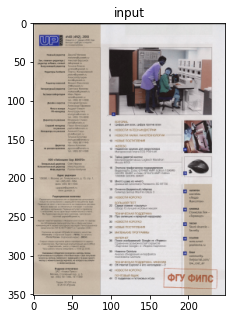

In [0]:
# input image
plt.figure(figsize=(10,5))
inp = cv2.imread(test_image)
plt.title("input")
plt.imshow(inp)

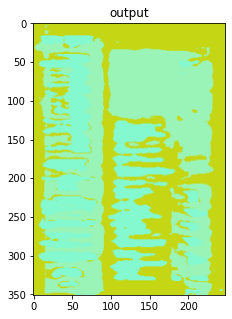

In [0]:
# output image
plt.figure(figsize=(10,5))
out = cv2.imread("/content/out.png")
plt.title("output")
plt.imshow(out)

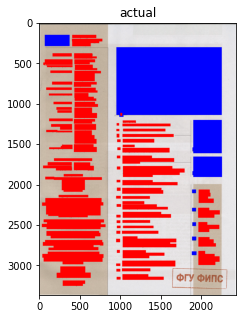

In [0]:
# actual image
plt.figure(figsize=(10,5))
actual = cv2.imread(actual_img)
plt.title("actual")
plt.imshow(actual)

#### Example - 2

In [0]:
test_image = "/content/content/data/test/images/5cw.png"
actual_img = "/content/dataset_segmentation/5cw_m.bmp"

In [0]:
  out = fcn.predict_segmentation(
    inp=test_image,
    out_fname="out.png")

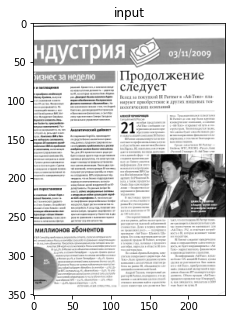

In [0]:
# input image
plt.figure(figsize=(10,5))
inp = cv2.imread(test_image)
plt.title("input")
plt.imshow(inp)

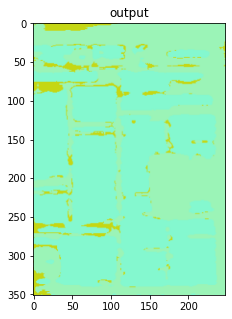

In [0]:
# output image
plt.figure(figsize=(10,5))
out = cv2.imread("/content/out.png")
plt.title("output")
plt.imshow(out)

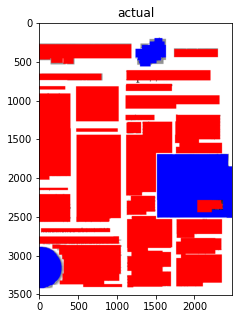

In [0]:
# actual image
plt.figure(figsize=(10,5))
actual = cv2.imread(actual_img)
plt.title("actual")
plt.imshow(actual)

#### Example - 3

In [0]:
test_image = "/content/content/data/test/images/22.png"
actual_img = "/content/dataset_segmentation/22_m.png"

In [0]:
  out = fcn.predict_segmentation(
    inp=test_image,
    out_fname="out.png")

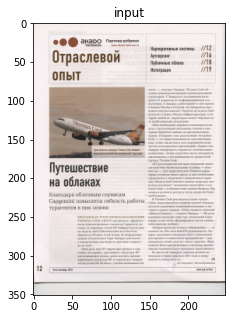

In [0]:
# input image
plt.figure(figsize=(10,5))
inp = cv2.imread(test_image)
plt.title("input")
plt.imshow(inp)

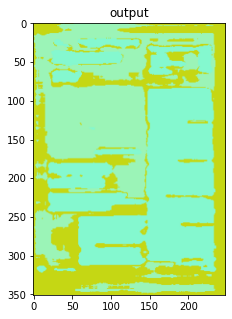

In [0]:
# output image
plt.figure(figsize=(10,5))
out = cv2.imread("/content/out.png")
plt.title("output")
plt.imshow(out)

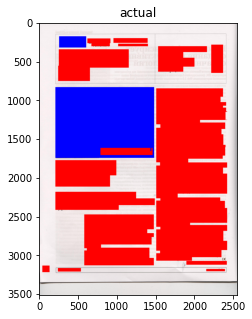

In [0]:
# actual image
plt.figure(figsize=(10,5))
actual = cv2.imread(actual_img)
plt.title("actual")
plt.imshow(actual)